In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
os.listdir('src')

['.ipynb_checkpoints', 'Walmart_Store_sales.csv']

In [3]:
df = pd.read_csv('src/Walmart_Store_sales.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


# Analyzation of features
Store: The store number
<br>Date: Specifying the Week (Friday of every Week)
<br> Temperature: Average temperature in the region (in ℉)
<br> FuelPrice: Cost of fuel in the region
<br> CPI: Consumer price index
<br> Unemployment: Unemployment rate
<br> Holiday_Flag: Whether the week is a special holiday week

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


In [5]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


# EDA and data preprocessing

* Drop lines where target values are missing

In [6]:
df.dropna(subset='Weekly_Sales',inplace=True)

In [7]:
df.isnull().sum()

Store            0
Date            18
Weekly_Sales     0
Holiday_Flag    11
Temperature     15
Fuel_Price      12
CPI             11
Unemployment    14
dtype: int64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

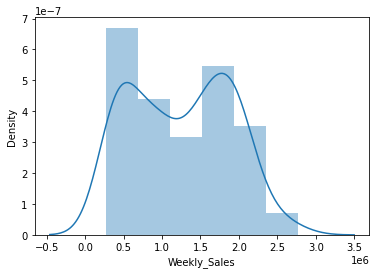

In [8]:
sns.distplot(df.Weekly_Sales)

* Create usable features from the Date column: year, month, day, day of week

In [9]:
df.Date=pd.to_datetime(df.Date)

/tmp/ipykernel_140/1999132107.py:1: UserWarning: Parsing '18-02-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df.Date=pd.to_datetime(df.Date)
/tmp/ipykernel_140/1999132107.py:1: UserWarning: Parsing '25-03-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df.Date=pd.to_datetime(df.Date)
/tmp/ipykernel_140/1999132107.py:1: UserWarning: Parsing '28-05-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df.Date=pd.to_datetime(df.Date)
/tmp/ipykernel_140/1999132107.py:1: UserWarning: Parsing '19-08-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df.Date=pd.to_datetime(df.Date)
/tmp/ipykernel_140/1999132107.py:1: UserWarning: Parsing '15-10-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df.Date=pd.to_dat

In [10]:
df.dtypes

Store                  float64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag           float64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

In [11]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_of_week'] = pd.DatetimeIndex(df['Date']).day_name()

In [12]:
df.day_of_week = df['day_of_week'].apply(lambda x: 1 if x == 'Monday'
                                        else 2 if x == 'Thursday'
                                        else 3 if x == 'Wednesday'
                                        else 4 if x == 'Thursday'
                                        else 5 if x == 'Friday'
                                        else 6 if x == 'Saturday'
                                        else 7 )

In [13]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,day_of_week
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,5
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,5
3,11.0,NaT,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,7
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,5
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010.0,5.0,28.0,5


* Drop lines containing outliers for columns Temperature, Fuel_price, CPI and Unemployment

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='Unemployment'>

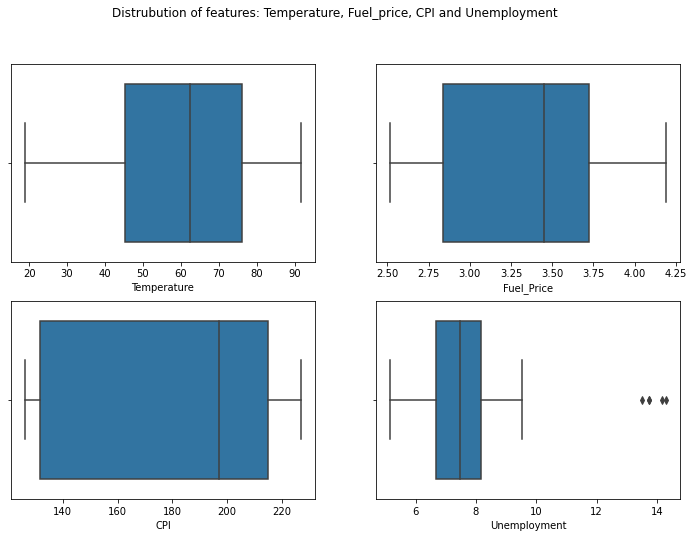

In [15]:
# Overview of distrubution of several features
fig, axes = plt.subplots(2,2,figsize=(12,8))

fig.suptitle('Distrubution of features: Temperature, Fuel_price, CPI and Unemployment')

charac = ['Temperature','Fuel_price','CPI','Unemployment']

sns.boxplot(ax=axes[0,0],data=df,x='Temperature',)
sns.boxplot(ax=axes[0,1],data=df,x='Fuel_Price')
sns.boxplot(ax=axes[1,0],data=df,x='CPI')
sns.boxplot(ax=axes[1,1],data=df,x='Unemployment')

In [16]:
def drop_outliers(col):
    
    outliers_min = df[col].mean() - 3*df[col].std()
    outliers_max = df[col].mean() + 3*df[col].std()
    
    keep_values = df[col].between(outliers_min,outliers_max,inclusive=True)
    return keep_values

In [17]:
mask = drop_outliers('Temperature') & drop_outliers('Fuel_Price') & drop_outliers('CPI') & drop_outliers('Unemployment')
df = df.loc[mask,:]

/tmp/ipykernel_140/1078195015.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  keep_values = df[col].between(outliers_min,outliers_max,inclusive=True)


In [18]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,day_of_week
count,90.000000,9.000000e+01,80.000000,90.00000,90.000000,90.000000,90.000000,80.000000,80.000000,80.000000,90.000000
mean,9.900000,1.233865e+06,0.075000,61.06100,3.318444,179.524905,7.389733,2010.887500,6.525000,15.962500,5.166667
std,6.204475,6.647250e+05,0.265053,17.74604,0.484399,39.554303,0.982729,0.826672,3.329861,8.594145,1.545199
min,1.000000,2.689290e+05,0.000000,18.79000,2.548000,126.128355,5.143000,2010.000000,1.000000,1.000000,1.000000
25%,4.000000,5.617240e+05,0.000000,45.34250,2.814750,132.602339,6.642250,2010.000000,4.000000,8.000000,5.000000
50%,9.000000,1.260826e+06,0.000000,61.45000,3.468000,197.166416,7.419000,2011.000000,6.000000,16.500000,5.000000
75%,15.750000,1.807159e+06,0.000000,75.79250,3.737750,214.855374,8.099000,2012.000000,9.250000,23.250000,7.000000
max,20.000000,2.771397e+06,1.000000,91.65000,4.170000,226.968844,9.342000,2012.000000,12.000000,31.000000,7.000000


* Preprocessings

In [19]:
Y = df.loc[:,'Weekly_Sales']
X = df.loc[:,[col for col in df.columns if col != 'Weekly_Sales']]

In [20]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

In [21]:
categorical_features = [0,2]
categorical_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('encoder',OneHotEncoder(drop='first'))])


numeric_features = [3,4,5,6,7,8,9,10]
numeric_transformer = Pipeline(steps = [
                                    ('imputer',SimpleImputer(strategy='mean')),
                                    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
                             transformers = [('num',numeric_transformer,numeric_features),
                                             ('cat', categorical_transformer,categorical_features)])


x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)


# Linear Regression model and regularization

* Modeling

In [22]:
regression = LinearRegression()
regression.fit(x_train,y_train)

LinearRegression()

In [23]:
print('Train set score is: ',regression.score(x_train,y_train))
print('Test set score is: ',regression.score(x_test,y_test))
print('features number: ', regression.n_features_in_)  # put a graphic later to compare predictions and true values

Train set score is:  0.9812851925744304
Test set score is:  0.9400201846508888
features number:  27


* check the std of test set

In [24]:
from sklearn.model_selection import cross_val_score

cross_val_score =cross_val_score(regression,x_train,y_train,cv=20)

print('mean is :',cross_val_score.mean())
print('std is :',cross_val_score.std())

mean is : 0.8923019054397026
std is : 0.1045835101895711


* Analyzation of features and their coefs

In [25]:
categorical_column_names = preprocessor.transformers_[1][1]['encoder'].categories_
categorical_column_names = np.append(categorical_column_names[0],categorical_column_names[1])
numerical_column_names = X.iloc[:, numeric_features].columns
all_column_names = np.append(numerical_column_names,categorical_column_names)

all_column_names

array(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year',
       'month', 'day', 'day_of_week', 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
       8.0, 9.0, 10.0, 11.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0,
       20.0, 0.0, 1.0], dtype=object)

In [36]:
all_column_names_modified = np.delete(all_column_names,np.where(all_column_names == 0.0))
all_column_names_modified = np.delete(all_column_names_modified,np.where(all_column_names == 9.0))

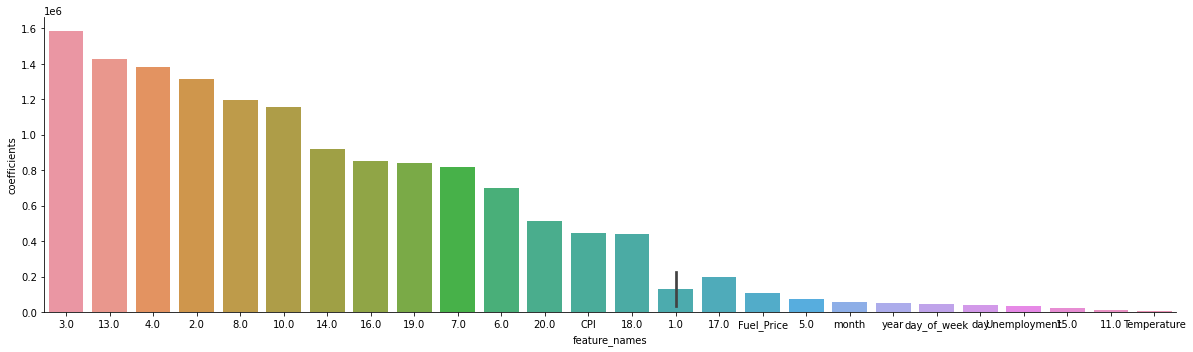

In [38]:
feature_importance = pd.DataFrame({
    "feature_names": all_column_names_modified,
    "coefficients":regression.coef_
})

feature_importance.sort_values(by='coefficients',ascending=False)

feature_importance["coefficients"] = feature_importance["coefficients"].abs()

# Visualize ranked features using seaborn
sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance.sort_values(by='coefficients',ascending=False), 
            kind="bar",
            aspect=30/9)

* Regularization - fight overfitting

In [57]:
# Try with Ridge
params = {'alpha': np.arange(0,10000,100)} 
ridge = Ridge()
gridsearch = GridSearchCV(ridge, params, cv = 10)

gridsearch.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
       4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
       5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500,
       6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600,
       7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700,
       8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800,
       9900])})

In [58]:
print('--------')
print('best_estimator: ',gridsearch.best_estimator_)
print('best_score: ', gridsearch.best_score_)

--------
best_estimator:  Ridge(alpha=0)
best_score:  0.855498063595163


In [59]:
print('train set score: ', gridsearch.score(x_train,y_train) )
print('test set score: ',gridsearch.score(x_test,y_test) )

train set score:  0.9812851925744303
test set score:  0.9400201846508898


In [60]:
# Try with Lasso
params = {'alpha': np.arange(0,10000,100)} 
lasso = Lasso()
gridsearch_lasso = GridSearchCV(lasso, params, cv = 15)

gridsearch_lasso.fit(x_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+11, tolerance: 2.965e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

GridSearchCV(cv=15, estimator=Lasso(),
             param_grid={'alpha': array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
       4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
       5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500,
       6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600,
       7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700,
       8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800,
       9900])})

In [61]:
print('--------')
print('best_estimator: ',gridsearch_lasso.best_estimator_)
print('best_score: ', gridsearch_lasso.best_score_)
print('number of features: ',gridsearch_lasso.n_features_in_)

--------
best_estimator:  Lasso(alpha=1300)
best_score:  0.9071544942041587
number of features:  27


In [62]:
print('train set score: ', gridsearch_lasso.score(x_train,y_train) )
print('test set score: ',gridsearch_lasso.score(x_test,y_test) )

train set score:  0.9784800950791722
test set score:  0.9362962296725764
